# CIR Model and cash vs ZC bonds

The Cox Ingersoll Ross model gives the changes in the interest rate at time t based on mean reversion of observed and long-term rates combined with a random measure tied to the volatility. It is an extension of the Vasicek model.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from my_modules import risk
from my_modules import data
from my_modules import portfolio
from my_modules import index
from my_modules import model

import numpy as np
import pandas as pd

In [11]:
## Short rate (instantaneous rate, e.g. a day) vs Annualised
# If we're compunding every 1/N of a year (i.e. n times per year), the annualised rate is = (1 + r/N)^N
# With very large values of N: 1 + annual_r = e^instant_r, i.e. instant_r = ln(1 + annual_r)

def inst_to_ann(r):
    """
    Converts short rate to an annualised rate
    """
    return np.expm1(r) # == np.exp(r) - 1

def ann_to_inst(r):
    """
    Converts annualised rate to short rate
    """
    return np.log1p(r) # == np.log(1 + r)

### CIR
$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

In [20]:
def cir_old(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Gives the change in interest rate according to the Cox Ingersoll Ross model.
    """
    if r_0 is None: r_0=b
    r_0 = ann_to_inst(r_0) #For small values of r the instantaneosu rate is not that different to the annual
    dt = 1/steps_per_year
    
    #dWt part requires random numbers, referred to as the shock
    num_steps = int(n_years * steps_per_year)
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        rt = rates[step - 1]
        d_r_t = a * (b - rt) + sigma*np.sqrt(rt)*shock[step]
        rates[step] = abs(rt + d_r_t) #This should be a positive number but to be safe with rouding errors/high shocks abs
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

In [4]:
%matplotlib inline

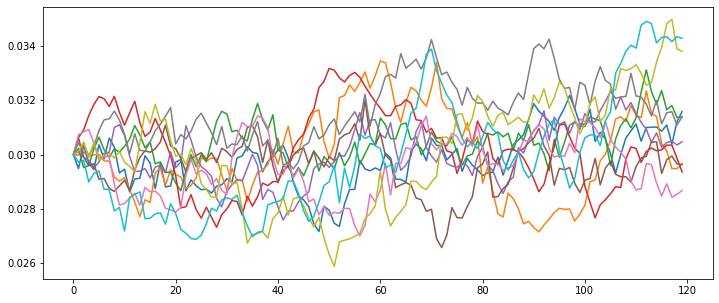

In [24]:
cir_old(n_scenarios=10, sigma=0.01).plot(figsize=(12,5), legend=False)

In [28]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=10):
    model.cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(figsize=(16,8), legend=False)
    
import ipywidgets as widgets
from IPython.display import display

controls = widgets.interactive(show_cir,
                              r_0=(0,.15,0.01),
                              a=(0,1,.1),
                              b=(0,.15,.01),
                              sigma=(0, .1, .01),
                              n_scenarios=(1,100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

## Calculating Price of A Zero Coupon (ZC) Bond

CIR can be adapted to find the price of ZC bonds.

The price of a bond at time t with a maturation at time T is given by:

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$

In [34]:
import math

def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Gives the random interest rate eveolution over time using the Cox Ingersoll Ross model.
    b and r_0 are assumed to be the annaulised (not short) rate, with the return values being given as annualised rates too.
    """
    if r_0 is None: r_0=b
    r_0 = ann_to_inst(r_0) #For small values of r the instantaneosu rate is not that different to the annual
    dt = 1/steps_per_year
    num_steps = int(n_years * steps_per_year) + 1 # One added as n_years might be given as a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    ## For price generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    
    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    
    prices[0] = price(n_years, r_0)
    
    for step in range(1, num_steps):
        rt = rates[step - 1]
        d_r_t = a * (b - rt) + sigma*np.sqrt(rt)*shock[step]
        rates[step] = abs(rt + d_r_t) #This should be a positive number but to be safe with rouding errors/high shocks abs
        # Generate a price at time t as well
        prices[step] = price(n_years-step*dt, rates[step])
        
    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    
    return rates, prices

In [36]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(figsize=(16,8), legend=False)
    
import ipywidgets as widgets
from IPython.display import display

controls = widgets.interactive(show_cir_prices,
                              r_0=(0,.15,0.01),
                              a=(0,1,.1),
                              b=(0,.15,.01),
                              sigma=(.01, .1, .01),
                              n_scenarios=(1,100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

Now, having the prices. We can simulate scenarios where a ZC bond is used as a hedge instead of cash.

In [38]:
cash_on_hand = .75 # .75MM in assets
rates, bond_prices = cir(n_years=10, r_0=0.03, b=0.03, n_scenarios=10)

#As the price of the bond change, the cost of paying off a dollar varies with that bond change
liabilities = bond_prices 
# What is the price of a ZC bond today?
zc_10 = pd.Series(data=[1], index=[10])
zc_0 = portfolio.pv(zc_10,r=0.03)

n_bonds = cash_on_hand/zc_0

asset_value_zc_bonds = n_bonds * bond_prices
asset_value_cash = cash_on_hand*(1 + rates/12).cumprod() # cumulative product of the month rate

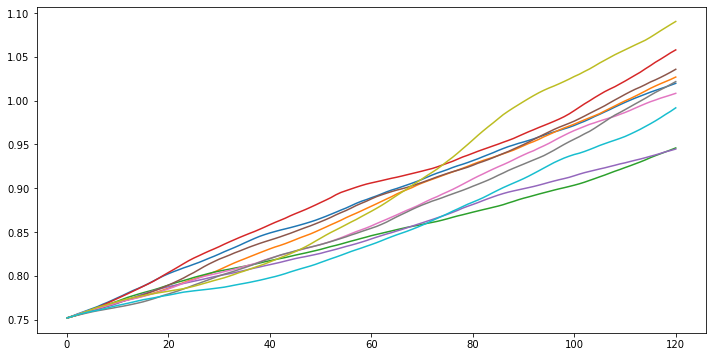

In [40]:
asset_value_cash.plot(legend=False, figsize=(12,6))

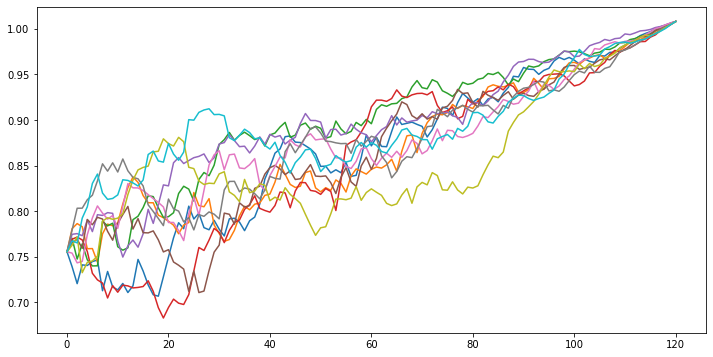

In [42]:
asset_value_zc_bonds.plot(legend=False, figsize=(12,6))

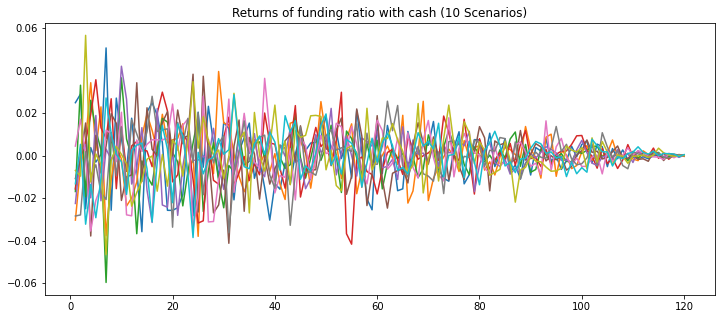

In [43]:
# Cash is risky and when looked at in terms of the funding ratio is more messy
(asset_value_cash/liabilities).pct_change().plot(title='Returns of funding ratio with cash (10 Scenarios)', legend=False, figsize=(12,5))

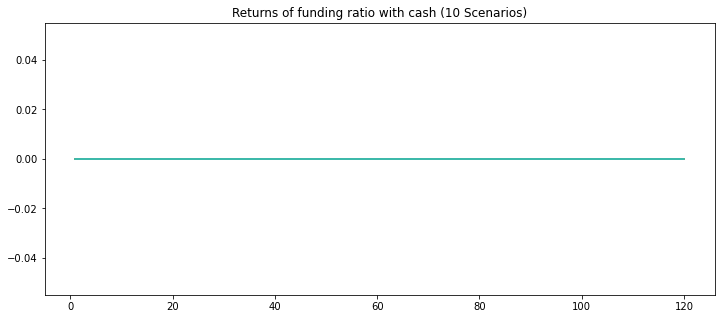

In [44]:
# With ZC bonds the funding ratio remains flat
(asset_value_zc_bonds/liabilities).pct_change().plot(title='Returns of funding ratio with cash (10 Scenarios)', legend=False, figsize=(12,5))

It is difficult to find (even as an institutional investor) to find zc that match the liabilities

In [47]:
## What is the range of outcomes when investing with different vehicles
a_0 = 0.75
rates, bond_prices = cir(n_scenarios=10000, r_0=0.03, b=0.03)
liabilities = bond_prices
zc_0 = portfolio.pv(zc_10, 0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds * bond_prices
av_cash = a_0 * (1 + rates/12).cumprod()

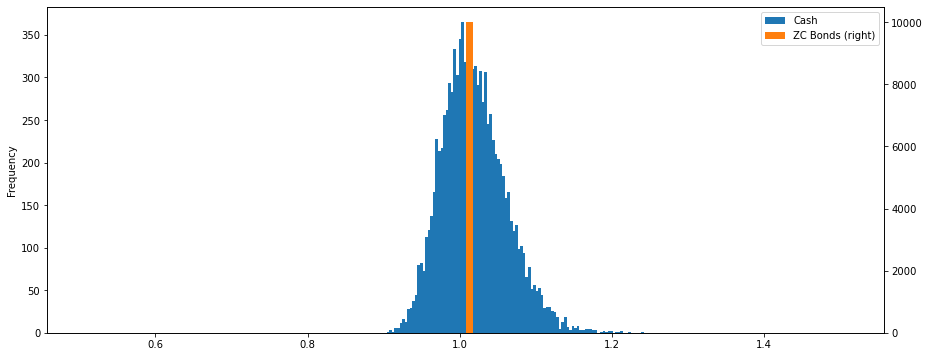

In [49]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]

ax = tfr_cash.plot.hist(label='Cash', figsize=(15,6), bins=100, legend=True)
tfr_bonds.plot.hist(ax=ax, label='ZC Bonds', bins=100, legend=True, secondary_y=True)

In [55]:
print('tfr_cash min = ' + str(np.min(tfr_cash)))
print('tfr_cash max = '  + str(np.max(tfr_cash)))

tfr_cash min = 0.9038873964106372
tfr_cash max = 1.241596203880906
